In [1]:
#import all libraries
import tensorflow         as tf
import numpy              as np
import matplotlib.pyplot  as plt
import matplotlib.patches as patches
import cv2
import csv

from PIL                                        import Image
from tensorflow.keras.applications.mobilenet    import preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models                    import Model
from tensorflow.keras.layers                    import Conv2D, Reshape

#random number generator
import random
random.seed(0)

#ignore warnings
import warnings 
warnings.filterwarnings('ignore')

In [2]:
#load the dataset
main_dataset        = "./101_ObjectCategories/"
main_train_csv      = "train.csv"
main_validation_csv = "validation.csv"

In [3]:
#getting traing data
image_size_intialization = 96

with open(main_train_csv, "r") as file:
    y_train = np.zeros((sum(1 for line in file), 4))
    x_train = [] 
    file.seek(0)
    data = csv.reader(file, delimiter = ',')
    
    for index, row in enumerate(data):
        for i, r in enumerate(row[1:7]):
            row[i+1] = int(r)
        path, image_width, image_height, x0, x1, y0, y1 = row #image dimentions, Boundary box coordinates
        
        y_train[index, 0] = x0 * image_size_intialization / image_width #normalization boundary box by image size
        y_train[index, 1] = y0 * image_size_intialization / image_height
        y_train[index, 2] = (x1 - x0) * image_size_intialization / image_width
        y_train[index, 3] = (y1 - y0) * image_size_intialization / image_height
        
        x_train.append(path)

In [4]:
#image path with the file name
x_train[501]

'./101_ObjectCategories/Train/Airplanes_Side_2/image_0457.jpg'

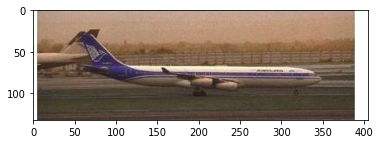

In [5]:
#display a perticular image
plt.imshow(cv2.imread(x_train[501]))

Image with detection boundary box:


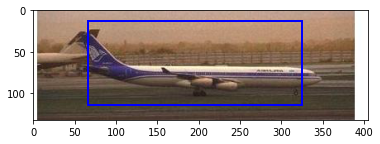

In [6]:
file_name = x_train[501]
unscaled  = cv2.imread(file_name)

region   = y_train[501]
image_height, image_width, _ = unscaled.shape

#scale the boundary box
x0 = int(region[0] * image_width / image_size_intialization)
y0 = int(region[1] * image_height/ image_size_intialization)
x1 = int((region[0] + region[2]) * image_width / image_size_intialization)
y1 = int((region[1] + region[3]) * image_height/ image_size_intialization)

fig, ax = plt.subplots(1)
ax.imshow(unscaled)
rectangle_box = patches.Rectangle((x0, y0), 
                                  x1 - x0, 
                                  y1 - y0, 
                                  linewidth = 2, 
                                  edgecolor = 'b', 
                                  facecolor = 'none')
ax.add_patch(rectangle_box)

print("Image with detection boundary box:")
plt.imshow(cv2.imread(x_train[501]))
plt.show()

In [7]:
for i, file in enumerate(x_train):
    image = Image.open(file)#read the image 
    image = image.resize((image_size_intialization, image_size_intialization))
    image = image.convert('RGB')
    
    x_train[i] = preprocess_input(np.array(image, dtype = np.float32))
    image.close()

In [8]:
type(x_train[501])

numpy.ndarray

In [9]:
x_train[501].shape

(96, 96, 3)

In [10]:
type(x_train)

list

In [11]:
#need to convert an array (list --> array)
x_train = np.array(x_train)
x_train.shape

(8321, 96, 96, 3)

In [12]:
#getting validation data
with open(main_validation_csv, "r") as file:
    y_validation = np.zeros((sum(1 for line in file), 4))
    x_validation = [] 
    file.seek(0)
    data = csv.reader(file, delimiter = ',')
    
    for index, row in enumerate(data):
        for i, r in enumerate(row[1:7]):
            row[i+1] = int(r)
        path, image_width, image_height, x0, x1, y0, y1 = row #image dimentions, Boundary box coordinates
        
        y_train[index, 0] = x0 * image_size_intialization / image_width #normalization boundary box by image size
        y_train[index, 1] = y0 * image_size_intialization / image_height
        y_train[index, 2] = (x1 - x0) * image_size_intialization / image_width
        y_train[index, 3] = (y1 - y0) * image_size_intialization / image_height
        
        x_validation.append(path)

In [13]:
for i, file in enumerate(x_validation):
    image = Image.open(file)#read the image 
    image = image.resize((image_size_intialization, image_size_intialization))
    image = image.convert('RGB')
    
    x_validation[i] = preprocess_input(np.array(image, dtype = np.float32))
    image.close()

In [14]:
#need to convert an array (list --> array)
x_validation = np.array(x_validation)
x_validation.shape

(356, 96, 96, 3)

In [15]:
#checking the shape of train data and validation data 
print("Shape of Train Data: \t\t", x_train.shape)
print("Shape of Validation Data: \t", x_validation.shape)

Shape of Train Data: 		 (8321, 96, 96, 3)
Shape of Validation Data: 	 (356, 96, 96, 3)


### Create a Model

In [20]:
#initialize the hyperperameter
my_alpha = 1.0

def create_model(trainable = True):
    model = MobileNetV2(input_shape = (image_size_intialization, 
                                     image_size_intialization, 3),
                                     include_top=False, 
                                     alpha=my_alpha)
    
    for layer in model.layers:
        layer.trainable = trainable
        
    x0 = model.layers[-1].output
    x1 = Conv2D(4, kernel_size = 3, name = 'coords')(x0)
    x2 = Reshape((4,))(x1) # 4 predicted coordinates of one Boundary Box
    return Model(inputs=model.input, outputs=x2)

### Model Evaluation with IoU (Intersection over Union)

In [21]:
def IOU(y_true, y_pred):
    
    intersections = 0
    unions = 0
    
    # set the types so we are sure what type we are using
    gt   = y_true
    pred = y_pred
    # Compute interection of predicted (pred) and ground truth (gt) bounding boxes
    diff_width   = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height  = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height

    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

    # Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + tensorflow.keras.backend.epsilon()), 4)
    
    # This must match the type used in py_func
    iou = iou.astype(np.float32)
    
    return iou

In [22]:
def IoU(y_true, y_pred):
    iou = tensorflow.py_function(IOU, [y_true, y_pred], Tout=tensorflow.float32)
    return iou

In [23]:
# Arg is False, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model(False) 

model.summary() # Print summary

9412608/9406464 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 48, 48, 32)   0           bn_Conv1[0][0]                   
_______________________________

In [24]:
#compile the model
model.compile(loss="mean_squared_error", optimizer="adam", metrics=[IoU]) # Regression loss is MSE

#### Train the model

In [26]:
import tensorflow
# Use earlystopping
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_IoU', patience=5, min_delta=0.01)

# Fit the model
my_model1 = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), epochs=10, batch_size=32, callbacks=[callback])

Epoch 1/10
261/261 [==============================] - 30s 109ms/step - loss: 290.8968 - IoU: 0.5684 - val_loss: 2863.2363 - val_IoU: 0.0348
Epoch 2/10
261/261 [==============================] - 29s 110ms/step - loss: 130.2541 - IoU: 0.6697 - val_loss: 2846.1521 - val_IoU: 0.0411
Epoch 3/10
261/261 [==============================] - 29s 110ms/step - loss: 104.6432 - IoU: 0.7005 - val_loss: 2960.0154 - val_IoU: 0.0383
Epoch 4/10
261/261 [==============================] - 29s 110ms/step - loss: 90.6821 - IoU: 0.7197 - val_loss: 3007.6997 - val_IoU: 0.0256
Epoch 5/10
261/261 [==============================] - 29s 111ms/step - loss: 80.9679 - IoU: 0.7330 - val_loss: 3014.2659 - val_IoU: 0.0342
Epoch 6/10
261/261 [==============================] - 29s 111ms/step - loss: 73.8920 - IoU: 0.7434 - val_loss: 2759.1248 - val_IoU: 0.0381


In [27]:
#model evaluation
model.evaluate(x_validation, y_validation)

12/12 [==============================] - 1s 99ms/step - loss: 2759.1248 - IoU: 0.0381


[2759.124755859375, 0.038091666996479034]

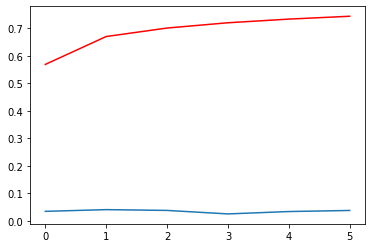

In [28]:
plt.plot(my_model1.history['IoU'], 'r')
plt.plot(my_model1.history['val_IoU'])

In [29]:
#model evaluation based on validation data
filename = '101_ObjectCategories\\validation\\dolphin\\image_0062.jpg'
unscaled = cv2.imread(filename) # Original image for display

In [30]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (image_size_intialization, image_size_intialization)) # Rescaled image

feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

print ("Size of original input: ", image.shape)
print("-------------------------------")
print("Size of scaled input: ", feat_scaled.shape)

Size of original input:  (96, 96, 3)
-------------------------------
Size of scaled input:  (96, 96, 3)


In [31]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the Boundary Box
region

array([20.053242, 10.847066, 37.059116, 54.337215], dtype=float32)

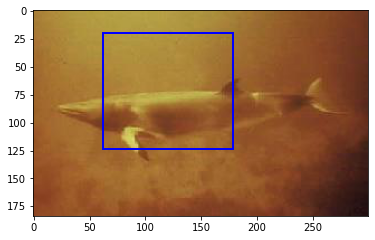

In [32]:
x0 = int(region[0] * image_width / image_size_intialization) # Scale the BBox
y0 = int(region[1] * image_height / image_size_intialization)

x1 = int((region[0] + region[2]) * image_width / image_size_intialization)
y1 = int((region[1] + region[3]) * image_height / image_size_intialization)

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rectangle_box = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='b', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rectangle_box)

plt.show()

**Interpretation:** This above object is detected but top and bottom consume some extra spaces. Let's evaluate one complex image wheather this model perfectly dectet or not 

In [34]:
#model evaluation based on validation data
filename = '101_ObjectCategories\\validation\\Faces_3\\image_0323.jpg'
unscaled = cv2.imread(filename) # Original image for display

In [35]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (image_size_intialization, image_size_intialization)) # Rescaled image

feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

print ("Size of original input: ", image.shape)
print("-------------------------------")
print("Size of scaled input: ", feat_scaled.shape)

Size of original input:  (96, 96, 3)
-------------------------------
Size of scaled input:  (96, 96, 3)


In [36]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the Boundary Box
region

array([ 4.014588, 12.157919, 84.594574, 67.497665], dtype=float32)

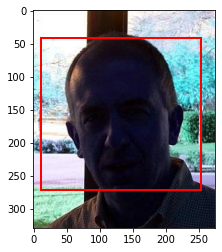

In [37]:
x0 = int(region[0] * image_width / image_size_intialization) # Scale the BBox
y0 = int(region[1] * image_height / image_size_intialization)

x1 = int((region[0] + region[2]) * image_width / image_size_intialization)
y1 = int((region[1] + region[3]) * image_height / image_size_intialization)

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rectangle_box = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rectangle_box)

plt.show()

**Interpretation**: Above image is perfectly detected by the model. Even the low light condition.

<center>---------------------------------------------END------------------------------------------------------</center>